Białowieża Forest is a lowland forest on the border between Belarus and Poland. It is scientifically important for being relatively untouched by human activity (in comparison to other European forests), with continuous forest cover for close to 12,000 years <a name="ref-1"/>[(Jaroszewicz et al., 2019)](#cite-f10100849). Jaroszewicz et al. note that even the areas that have been managed for eg. logging has the opportunity to recover, though there has been conflict about the management of this forest for close to a century. Other papers disagree with this assessment, and argue that the impacts of logging are felt well beyond the logging site, not least because it increases the fragmentation of the forest <a name="ref-2"/>[(Mikusiński et al., 2018)](#cite-MIKUSINSKI2018266). Some parts of the forest are protected within Białowieża National Park, though it currently does not extend to the entire forest.


Białowieża Forest is well-known for having rare European bison, with about 800 of them. (https://www.reuters.com/article/latestCrisis/idUSLN291035)

In [89]:
!pip install geopandas
!pip install requests
!pip install folium
!pip install matplotlib
!pip install seaborn
!pip install rtree
!pip install pygeos

You should consider upgrading via the '/home/corv/Documents/misc/outreachy/venv/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/home/corv/Documents/misc/outreachy/venv/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/home/corv/Documents/misc/outreachy/venv/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/home/corv/Documents/misc/outreachy/venv/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/home/corv/Documents/misc/outreachy/venv/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/home/corv/Documents/misc/outreachy/venv/bin/python -m pip install --upgrade pip' command.
     |████████████████████████████████| 2.2 MB 2.1 MB/s eta 0:00:01
You should consider upgrading via the '/home/corv/Documents/misc/outreachy/venv/bin/python -m pip install --upgrade pip' command.


In [1]:
#imports
import geopandas as gpd

# for download and decompress the dataset
import os, zipfile, glob, io, requests

# for SIG and spatial info management
from shapely.geometry import Polygon, shape

# for SIG and spatial visualization
import folium
from folium import Choropleth
from folium.plugins import HeatMap

# for dataframes and numerical info management
import numpy as np
import pandas as pd
import rtree
import pygeos

# for plot and graphs
import matplotlib.pyplot as plt
import seaborn as sns

# Ignore warning about missing/empty geometries
import warnings
warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
plt.rcParams.update({'figure.max_open_warning': 0})

/home/corv/Documents/misc/outreachy/venv/lib/python3.10/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


In [2]:
def read_df(url):
    content = requests.get(url).content
    return gpd.read_file(io.StringIO(content.decode('utf-8')))

In [29]:
! wget https://datasets.mojaglobal.workers.dev/0:/Administrative/Protected%20Areas/World%20Database%20of%20Protected%20Areas%20WDPA/WDPA_JSON_processedNationalOnly_ALL.zip

--2022-04-14 21:43:27--  https://datasets.mojaglobal.workers.dev/0:/Administrative/Protected%20Areas/World%20Database%20of%20Protected%20Areas%20WDPA/WDPA_JSON_processedNationalOnly_ALL.zip
SSL_INIT
Loaded CA certificate '/etc/ssl/certs/ca-certificates.crt'
Resolving datasets.mojaglobal.workers.dev (datasets.mojaglobal.workers.dev)... 2606:4700:3034::ac43:c9ca, 2606:4700:3035::6815:3cd6, 104.21.60.214, ...
Connecting to datasets.mojaglobal.workers.dev (datasets.mojaglobal.workers.dev)|2606:4700:3034::ac43:c9ca|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1329721504 (1.2G) [application/x-zip-compressed]
Saving to: ‘WDPA_JSON_processedNationalOnly_ALL.zip’

WDPA_JSON_processed 100%[===================>]   1.24G  4.14MB/s    in 4m 54s  

2022-04-14 21:48:24 (4.31 MB/s) - ‘WDPA_JSON_processedNationalOnly_ALL.zip’ saved [1329721504/1329721504]



In [27]:
# this was attempted, but I can't unzip it. 
# might be a linux thing - manually attempting also throws a "compression method not supported" error.

wdpa_df = gpd.read_file("WDPA_JSON_processedNationalOnly_ALL.zip")

DriverError: cpl_unzOpenCurrentFile() failed

# Administrative Boundaries

Białowieża Forest is in both Belarus and Poland. Specifically, it is contained within the provinces/states of Podlaskie, Hrodna, and Brest, which have been highlighted as below.

In [6]:
belarus_df = read_df("https://datasets.mojaglobal.workers.dev/0:/Administrative/Boundaries/Level2%20by%20Country/BLR/BLR_AL2_Belarus_GEZ.json")
poland_df = read_df("https://datasets.mojaglobal.workers.dev/0:/Administrative/Boundaries/Level2%20by%20Country/POL/POL_AL2_Poland_GEZ.json")
brest_df = read_df("https://datasets.mojaglobal.workers.dev/0:/Administrative/Boundaries/Level4%20by%20State/BLR/BLR_AL4_Brest%20Region_GEZ.json")
hrodna_df = read_df("https://datasets.mojaglobal.workers.dev/0:/Administrative/Boundaries/Level4%20by%20State/BLR/BLR_AL4_Hrodna%20Region_GEZ.json")
podlaskie_df  = read_df("https://datasets.mojaglobal.workers.dev/0:/Administrative/Boundaries/Level4%20by%20State/POL/POL_AL4_Podlaskie%20Voivodeship_GEZ.json")

In [7]:
belarus_df = belarus_df[["name","gez_name","geometry"]]
poland_df = poland_df[["name", "gez_name","geometry"]]
brest_df = brest_df[["name","gez_name", "geometry"]]
hrodna_df = hrodna_df[["name","gez_name","geometry"]]
podlaskie_df = podlaskie_df[["name","gez_name","geometry"]]
#set_crs might be needed

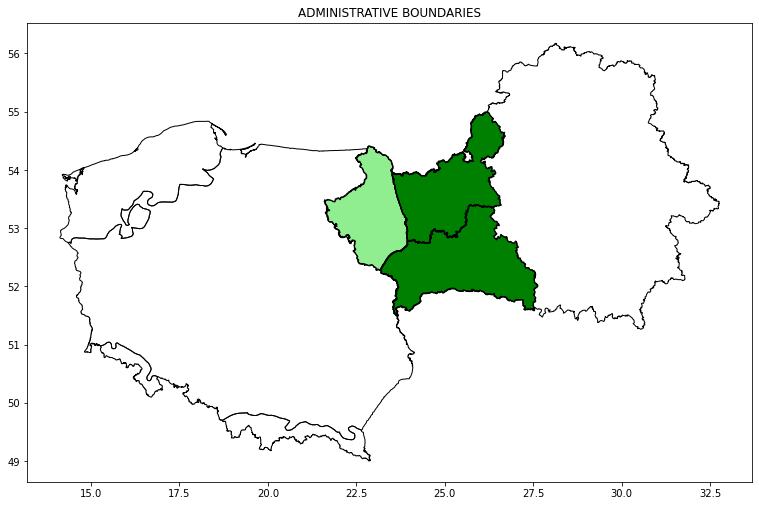

In [8]:
forest_df = pd.concat([hrodna_df,podlaskie_df,brest_df], axis=0)
boundaries_df = pd.concat([forest_df, belarus_df, poland_df ], axis=0)
fig, ax = plt.subplots(1, 1, figsize=(13, 10))

#colouring the regions with the forest
brest_df.plot(ax = ax, color="green", edgecolor="black")
hrodna_df.plot(ax = ax, color="green", edgecolor="black")
podlaskie_df.plot(ax = ax, color="lightgreen", edgecolor="black")

ax.set_title('ADMINISTRATIVE BOUNDARIES')

boundaries_df.plot(ax=ax, color='none', edgecolor='black')

plt.show()

# Ecological regions, climate, soil

Because the forest is comparatively small, it is anticipated that this data will be constant for the whole forest.

In [72]:
forest_df[["name","gez_name"]]

,name,gez_name
0,Hrodna Region,Temperate continental forest
0,Podlaskie Voivodeship,Temperate continental forest
0,Brest Region,Temperate continental forest


### Holdridge Zones

In [4]:
holdridge_zones = read_df('https://datasets.mojaglobal.workers.dev/0:/Bioclimatic&EcologicalZones/HoldridgeLifeZones.json')

In [9]:
holdridge_zones = holdridge_zones[["DESC", "geometry"]]
forest_holdridge = holdridge_zones.clip(forest_df)

In [10]:
forest_holdridge

,DESC,geometry
558,Cool temperate moist forest,"POLYGON ((26.38367 53.32214, 26.40221 53.31922..."


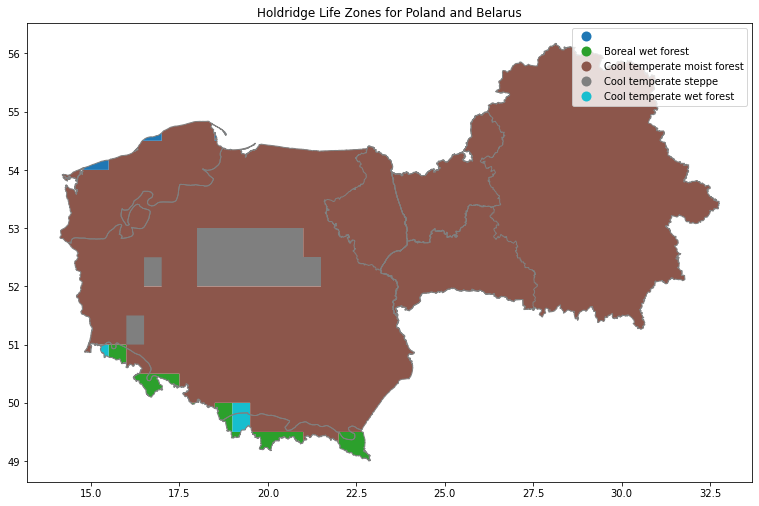

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(13, 10))

ax.set_title('Holdridge Life Zones for Poland and Belarus')

boundaries_holdridge = holdridge_zones.clip(boundaries_df)
boundaries_holdridge.plot(ax=ax, column='DESC', legend=True)
boundaries_df.plot(ax=ax, color='none', edgecolor='grey')
plt.show()

The above is mainly for comparison, particularly since a lot of the "forests" will just be urban cities, but it potentially does give a picture of what conditions the primeval forest that used to cover Europe would have.

# Anthropogenic Impact


This is especially interesting for the Poland side of the forest, since that is where the logging largely is.

### Hansen Global Forest Change

# References

<a name="cite-f10100849"/><sup>[^](#ref-1) </sup>Jaroszewicz, Bogdan and Cholewińska, Olga and Gutowski, Jerzy M. and Samojlik, Tomasz and Zimny, Marcelina and Latałowa, Małgorzata. 2019. _Białowieża Forest—A Relic of the High Naturalness of European Forests_. [URL](https://www.mdpi.com/1999-4907/10/10/849)

<a name="cite-MIKUSINSKI2018266"/><sup>[^](#ref-2) </sup>Mikusiński,Grzegorz and Bubnicki,Jakub Witold and Churski,Marcin and Czeszczewik,Dorota and Walankiewicz,Wiesław and Kuijper,Dries P.J.. 2018. _Is the impact of loggings in the last primeval lowland forest in Europe underestimated? The conservation issues of Białowieża Forest_. [URL](https://www.sciencedirect.com/science/article/pii/S0006320717321390)

